## Конфигурация, импорт и установка библиотек

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/MyDrive/flagmans

/content/gdrive/MyDrive/flagmans


In [ ]:
!pip install calmap

!pip install shap

!pip install pyproj==1.9.6

!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

     |████████████████████████████████| 358kB 12.2MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491632 sha256=88eda2da3537c8bbfc1425d4b4b400bd2ab7e45a0d02c36a790694ba9ceeee52
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 2.8MB 13.5MB/s 
  Created wheel for pyproj: filename=pyproj-1.9.6-cp37-cp37m-linux_x86_64.whl size=3702435 sha256=c3bbc9309573c34ec4ee8b4e35aa031d481860229455c4fc4a2f7a64f28ae9fa
  Stored in directory: /root/.cache/pip/wheels/02/cd/b1/a2d6430f74c7a778a43d62f78bec109ca69c732dc9b929142a
Successfully built pyproj
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree   

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns

import calmap

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import xgboost as xgb

import shap

%matplotlib inline
sns.set_style('whitegrid')
pylab.rcParams['figure.figsize'] = 8, 6

In [ ]:
RAIF_PATH = 'raif_data.csv'
SEED = 2021

## Концепт идеи

Суть идеи - рекомендовать клиентам продукты, которые могут их заинтересовать на основе транзакционных данных  

### Кластеризация & Классификация

https://evergreens.com.ua/ru/articles/classical-machine-learning.html

![](https://evergreens.com.ua/assets/images/articles/Kudelya-images/ml/Article1-learning.jpg)

**Классификация** – наиболее популярная задача машинного обучения. Она в чем-то схожа с тем, как ребенок учится определять форму и размер предметов, складывая их в раздельные кучки.

Задача классификации: **предсказание категории объекта и разделение объектов согласно определенным и заданным заранее признакам**. То есть машина сортирует данные по нужным категориям: одежду – по цветам, сезонам или ткани, книги – по жанрам, авторам, языкам написания, соусы – по степени остроты, письма – по личной или рабочей направленности, спам-составляющей и т.д.

**Кластерный анализ**  — задача разбиения заданной выборки данных (объектов) так, чтобы каждый кластер состоял из схожих объектов, а объекты разных кластеров значительно отличались друг от друга.

Задача кластеризации: используя все имеющиеся данные, **предсказать соответствие объектов выборки их классам, сформировав таким образом кластеры**.


Пайплайн: последовательное применение кластеризации клиентов и затем классификации новых клиентов по определенным классам

Проблемы:

 
*   Наивный подход.
*   Шаблонизация пользователей.
*   Требует мониторинга и переобучения / замены после обкатки в проде.



## Загрузка

Изначальная задача, под которую был сгенерирован датасет, - определить домашний и рабочий адрес клиента с точностью 0.02 градуса (~1-2 км)

In [ ]:
data = pd.read_csv(RAIF_PATH, index_col='Unnamed: 0')
data = data[data['country'] == 'RUS']
data.head()

Columns (2,12) have mixed types.Specify dtype option on import or set low_memory=False.
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_adress_lat,pos_adress_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
0,2.884034,NaN,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,11606fde0c814ce78e0d726e39a0a5ee,2017-07-15,59.847,30.177
3,2.787498,NaN,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,6c5e5793ebc984fb72875feffff62854,2017-09-09,59.847,30.177
4,2.892510,NaN,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,0576445d74e374c92c0902e612fca356,2017-07-06,59.847,30.177
5,2.909018,NaN,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,af0d099257ccedbfe730c63a491e0d84,2017-08-23,59.847,30.177
6,2.801228,NaN,NaN,NaN,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NaN,59.844072,30.179153,0576445d74e374c92c0902e612fca356,2017-07-29,59.847,30.177


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038879 entries, 0 to 1224732
Data columns (total 18 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   amount            1038879 non-null  float64
 1   atm_address       214138 non-null   object 
 2   atm_address_lat   147724 non-null   float64
 3   atm_address_lon   147724 non-null   float64
 4   city              1038871 non-null  object 
 5   country           1038879 non-null  object 
 6   currency          1038879 non-null  float64
 7   customer_id       1038879 non-null  object 
 8   home_add_lat      1038865 non-null  float64
 9   home_add_lon      1038865 non-null  float64
 10  mcc               1038879 non-null  int64  
 11  pos_address       803539 non-null   object 
 12  pos_adress_lat    819103 non-null   float64
 13  pos_adress_lon    819103 non-null   float64
 14  terminal_id       1038879 non-null  object 
 15  transaction_date  1038879 non-null  object 
 16  

## Препроцессинг

In [ ]:
data.isna().sum()

amount                   0
atm_address         824741
atm_address_lat     891155
atm_address_lon     891155
city                     8
country                  0
currency                 0
customer_id              0
home_add_lat            14
home_add_lon            14
mcc                      0
pos_address         235340
pos_adress_lat      219776
pos_adress_lon      219776
terminal_id              0
transaction_date         0
work_add_lat        477692
work_add_lon        477692
dtype: int64

#### Категориальные признаки

In [ ]:
obj_cols = ['atm_address', 'pos_address', 'terminal_id', 'city']

In [ ]:
data[obj_cols] = data[obj_cols].fillna(value='NA')

In [ ]:
data[obj_cols].nunique()

atm_address     14228
pos_address     85074
terminal_id    193540
city             5736
dtype: int64

In [ ]:
le = LabelEncoder()
le.fit(data['city'])
data['city'] = le.transform(data['city'])

In [ ]:
data['currency'] = data['currency'].astype(int)

In [ ]:
data.head()

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_adress_lat,pos_adress_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
0,2.884034,NA,NaN,NaN,4495,RUS,643,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NA,59.844072,30.179153,11606fde0c814ce78e0d726e39a0a5ee,2017-07-15,59.847,30.177
3,2.787498,NA,NaN,NaN,4495,RUS,643,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NA,59.844072,30.179153,6c5e5793ebc984fb72875feffff62854,2017-09-09,59.847,30.177
4,2.892510,NA,NaN,NaN,4495,RUS,643,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NA,59.844072,30.179153,0576445d74e374c92c0902e612fca356,2017-07-06,59.847,30.177
5,2.909018,NA,NaN,NaN,4495,RUS,643,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NA,59.844072,30.179153,af0d099257ccedbfe730c63a491e0d84,2017-08-23,59.847,30.177
6,2.801228,NA,NaN,NaN,4495,RUS,643,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,NA,59.844072,30.179153,0576445d74e374c92c0902e612fca356,2017-07-29,59.847,30.177


#### Сумма транзакции - amount

Среднее 2.812674453715392
Минимум -2.0123559735
Максимум 6.075306611699999
Медиана 2.7227227952999997


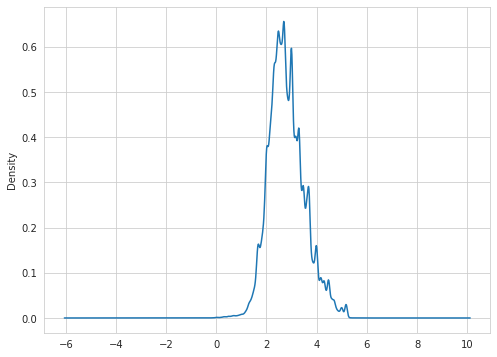

In [ ]:
print('Среднее', np.mean(data.amount))
print('Минимум', np.min(data.amount))
print('Максимум', np.max(data.amount))
print('Медиана', np.median(data.amount))

data.amount.sort_values().plot.kde()

In [ ]:
def amount_reverse_transform(amount):
  return np.exp(amount) * 100

In [ ]:
data['amount'] = data['amount'].apply(lambda x: amount_reverse_transform(x))

Среднее 2220.149869676795
Минимум 13.367337246964132
Максимум 43498.28529038884
Медиана 1522.1711476647388


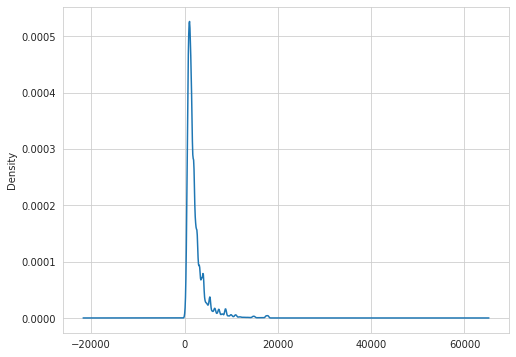

In [ ]:
print('Среднее', np.mean(data.amount))
print('Минимум', np.min(data.amount))
print('Максимум', np.max(data.amount))
print('Медиана', np.median(data.amount))

data.amount.sort_values().plot.kde()

#### Агрегаты по mcc

In [ ]:
# TODO: добавить cуммы в месяц / неделю

In [ ]:
data.groupby(['customer_id', 'mcc'], as_index=False).agg({'amount': ['count', 'mean', 'sum']}).head()

customer_id   mcc amount                           
                                           count         mean           sum
0  0001f322716470bf9bfc1708f06f00fc  5211      1  2317.558546   2317.558546
1  0001f322716470bf9bfc1708f06f00fc  5411     11  1229.203597  13521.239572
2  0001f322716470bf9bfc1708f06f00fc  5499      1   911.213011    911.213011
3  0001f322716470bf9bfc1708f06f00fc  5541      6  2011.279524  12067.677143
4  0001f322716470bf9bfc1708f06f00fc  5912      1   971.277515    971.277515

## MCC

Вектор сумм транзакций по mcc для каждого пользователя

In [ ]:
data.groupby(['customer_id', 'mcc'], as_index=False).sum()[['customer_id', 'mcc', 'amount']].head()

,customer_id,mcc,amount
0,0001f322716470bf9bfc1708f06f00fc,5211,2317.558546
1,0001f322716470bf9bfc1708f06f00fc,5411,13521.239572
2,0001f322716470bf9bfc1708f06f00fc,5499,911.213011
3,0001f322716470bf9bfc1708f06f00fc,5541,12067.677143
4,0001f322716470bf9bfc1708f06f00fc,5912,971.277515


In [ ]:
payments_vs = data.groupby(['customer_id', 'mcc'])['amount'].aggregate('first').unstack().fillna(0)
payments_vs.head()

mcc,742,763,780,1711,1731,1750,1761,1799,2741,2842,3011,3047,3351,3501,3503,3504,3509,3512,3530,3533,3543,3553,3579,3586,3604,3634,3640,3642,3649,3665,3692,3710,3750,3778,4111,4112,4119,4121,4131,4214,...,7832,7911,7922,7929,7932,7933,7941,7991,7992,7994,7995,7996,7997,7998,7999,8011,8021,8042,8043,8050,8062,8071,8099,8111,8211,8220,8244,8249,8299,8351,8398,8661,8699,8911,8999,9211,9222,9311,9399,9402
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0001f322716470bf9bfc1708f06f00fc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
0007297d86e14bd68bd87b1dbdefe302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1997.585291,3398.369095,0.0,0.0,0.0,0.0,...,1189.218987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10960.839789,0.0,0.0,0.0,0.0,0.0,753.532562,0.0,0.0,0.0,0.0,0.0
000b709c6c6fb1e8efcfd95e57c2a9de,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1498.689891,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
0027a7618d97cc9fbda55fac457eaeb7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,688.252756,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
002b9f6e118c54f1292e03d1a04d516e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2483.441165,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


Разреженность - 95%

In [ ]:
(payments_vs.to_numpy() == 0).mean()

0.9500843858380162

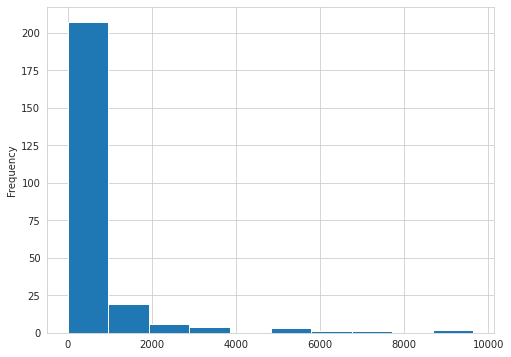

In [ ]:
payments_vs.astype(bool).sum(axis=0).sort_values(ascending=False).plot.hist()

In [ ]:
mcc_value_counts = payments_vs.astype(bool).sum(axis=0).sort_values(ascending=False)
mcc_value_counts

mcc
5411    9647
6011    8945
5814    6930
5912    6602
5812    5315
        ... 
7512       1
5044       1
8249       1
8244       1
5998       1
Length: 243, dtype: int64

Укрупнение mcc по категориям

In [ ]:
mcc = pd.read_csv('mcc.csv', index_col='MCC')
mcc.head()

,Description_1,Description_2
MCC,,
9998,Not Classified,Not Classified
9950,Прочие розничные покупки,Intra-Company Purchases
9405,Прочие розничные покупки,Intra Government Purchases
9402,Почтовые услуги,"Услуги отправки, обработки писем и посылок, пр..."
9399,Прочие розничные покупки,Government Services


In [ ]:
data['mcc_d1'] = data['mcc'].apply(lambda x: mcc.loc[x]['Description_1'])
data['mcc_d2'] = data['mcc'].apply(lambda x: mcc.loc[x]['Description_2'])

In [ ]:
aggs = False

if aggs: #payments_aggs[('amount','count','Cash')]
  payments_groupped_vs = data.groupby(['customer_id', 'mcc_d1'], as_index=False).agg({'amount': ['count', 'mean', 'sum']}).groupby(['customer_id', 'mcc_d1']).aggregate('first').unstack().fillna(0)
else:
  payments_groupped_vs = data.groupby(['customer_id', 'mcc_d1'])['amount'].aggregate('median').unstack().fillna(0)
payments_groupped_vs.head()

mcc_d1,Advertising Services,Business Services,Cash,Casino,Caterers,Computer Network/Informatio,Duty Free,Mail/Telephone/Preauth order,Not Classified,Other Services (Not Elsewhe,Transportation,Авиабилеты,Автоуслуги,Аптеки,Аренда авто,Гостиницы,"Дом, Ремонт",Ж/д билеты,Животные,Искусство,Кино,Книги,Коммунальные услуги,Красота,Музыка,"Одежда, Обувь",Почтовые услуги,Прочие розничные покупки,Развлечения,Рестораны,Спорттовары,Сувениры,Супермаркеты,Топливо,Транспорт,Универсальные магазины,Фаст Фуд,"Фото, Видео",Цветы
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0001f322716470bf9bfc1708f06f00fc,0.0,0.0,4066.455236,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,971.277515,0.0,0.000000,2317.558546,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1355.503861,0.0,0.000000,0.000000,0.000000,1038.698237,2036.983630,0.000000,0.00000,0.000000,0.0,0.000000
0007297d86e14bd68bd87b1dbdefe302,0.0,0.0,3627.691507,0.0,0.0,0.0,0.000000,3061.217097,784.818543,0.0,0.0,0.0,0.000000,1205.279366,0.0,0.000000,2107.296950,3398.369095,0.0,0.0,1107.563852,1891.273587,0.0,1423.377051,0.0,2052.073612,0.0,1508.278301,0.0,1355.777517,0.000000,1581.647661,1623.418566,1507.113503,1380.218322,0.00000,1048.457940,0.0,1981.830294
000b709c6c6fb1e8efcfd95e57c2a9de,0.0,0.0,2412.899726,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1443.925043,0.000000,0.0,3425.199471,2848.444772,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,4584.301058,0.0,1233.151036,0.0,1168.227703,1856.326240,0.000000,1262.386641,0.000000,1465.605381,0.00000,1606.538528,0.0,0.000000
0027a7618d97cc9fbda55fac457eaeb7,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1523.306457,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1981.666929,0.000000,688.252756,0.00000,0.000000,0.0,0.000000
002b9f6e118c54f1292e03d1a04d516e,0.0,0.0,4094.129581,0.0,0.0,0.0,1903.767679,0.000000,0.000000,0.0,0.0,0.0,0.000000,1381.428355,0.0,0.000000,2576.524520,0.000000,0.0,0.0,0.000000,1997.847056,0.0,2611.119189,0.0,3861.801275,0.0,5972.836783,0.0,1011.546791,2079.866205,0.000000,1203.358226,0.000000,2483.441165,1211.57822,1169.698906,0.0,2638.720102


Разреженность - 77%

In [ ]:
(payments_groupped_vs.to_numpy() == 0).mean()

0.7731597396094141

In [ ]:
payments_groupped_vs.astype(bool).sum(axis=0).sort_values(ascending=False)

mcc_d1
Супермаркеты                    9709
Cash                            8948
Фаст Фуд                        6930
Аптеки                          6606
Одежда, Обувь                   6285
Прочие розничные покупки        6015
Рестораны                       5424
Топливо                         5214
Дом, Ремонт                     5132
Универсальные магазины          4271
Красота                         3824
Транспорт                       3586
Спорттовары                     2233
Автоуслуги                      2208
Книги                           1555
Животные                        1475
Кино                            1380
Цветы                           1367
Развлечения                     1362
Mail/Telephone/Preauth order    1282
Not Classified                   996
Гостиницы                        829
Сувениры                         436
Duty Free                        327
Ж/д билеты                       282
Фото, Видео                      173
Коммунальные услуги            

## PCA

In [ ]:
pca = PCA(n_components=3)
pca.fit(payments_groupped_vs)
result = pca.transform(payments_groupped_vs)

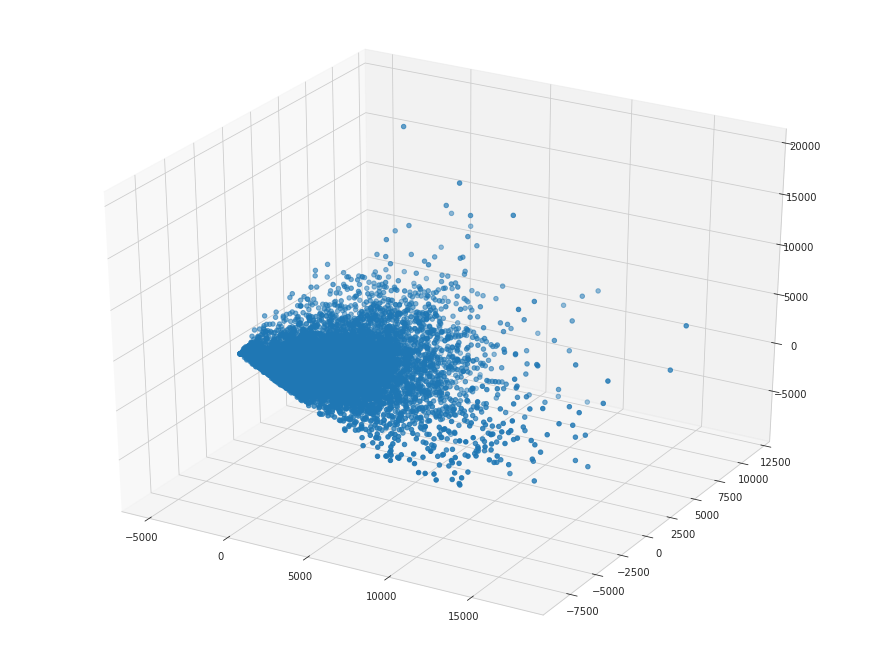

In [ ]:
fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)
x = result[:, 0]
y = result[:, 1]
z = result[:, 2]
ax.scatter(x, y, z, cmap='coolwarm')

In [ ]:
pca.explained_variance_

array([8459191.74118184, 5326851.01064366, 2715132.52368301])

## Кластеризация

CPU times: user 28.9 s, sys: 21 s, total: 49.8 s
Wall time: 26.6 s


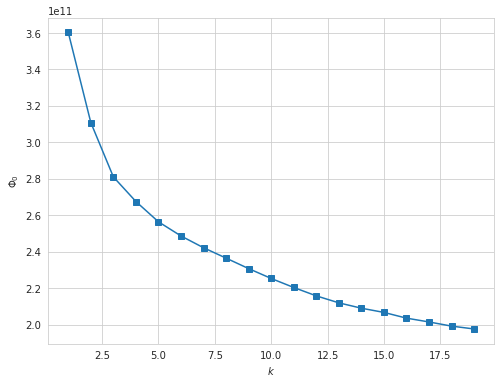

In [ ]:
%%time

inertia = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=SEED).fit(payments_groupped_vs)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 20), inertia, marker='s')
plt.xlabel('$k$')
plt.ylabel('$\Phi_0$')

In [ ]:
%%time
num_classes = 4
kmeans = KMeans(n_clusters=num_classes, random_state=SEED).fit(payments_groupped_vs)
res = kmeans.labels_

CPU times: user 724 ms, sys: 589 ms, total: 1.31 s
Wall time: 678 ms


### Оценка качества кластеризации

In [ ]:
silhouette_score(payments_groupped_vs, res)

0.1548176316997482

### Визуализация на PCA

https://github.com/pacifikus/Algebraic-immunity-exploration/blob/master/Component_AI_Visualization_3.ipynb

In [ ]:
res = [i + 1 for i in res]

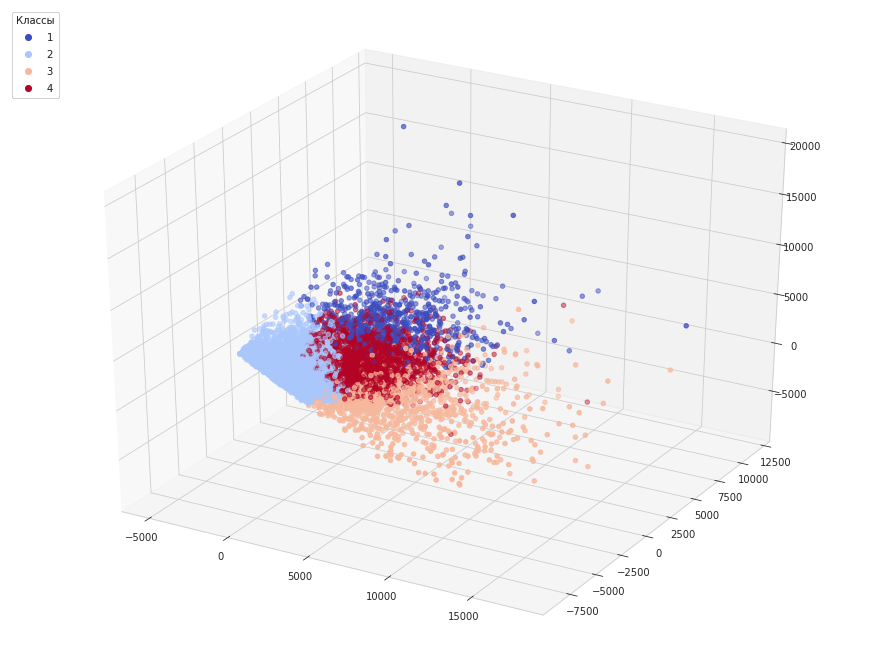

In [ ]:
fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)
x = result[:, 0]
y = result[:, 1]
z = result[:, 2]
scatter = ax.scatter(x, y, z, c=res, cmap='coolwarm')
legend1 = ax.legend(*scatter.legend_elements(num=3),
                    loc="upper left", title="Классы")
ax.add_artist(legend1)

In [ ]:
payments_groupped_vs['label'] = res

In [ ]:
payments_groupped_vs = pd.get_dummies(payments_groupped_vs, columns=['label'])
payments_groupped_vs.head()

,Advertising Services,Business Services,Cash,Casino,Caterers,Computer Network/Informatio,Duty Free,Mail/Telephone/Preauth order,Not Classified,Other Services (Not Elsewhe,Transportation,Авиабилеты,Автоуслуги,Аптеки,Аренда авто,Гостиницы,"Дом, Ремонт",Ж/д билеты,Животные,Искусство,Кино,Книги,Коммунальные услуги,Красота,Музыка,"Одежда, Обувь",Почтовые услуги,Прочие розничные покупки,Развлечения,Рестораны,Спорттовары,Сувениры,Супермаркеты,Топливо,Транспорт,Универсальные магазины,Фаст Фуд,"Фото, Видео",Цветы,label_0,label_1,label_2,label_3
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0001f322716470bf9bfc1708f06f00fc,0.0,0.0,4066.455236,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,971.277515,0.0,0.000000,2317.558546,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1355.503861,0.0,0.000000,0.000000,0.000000,1038.698237,2036.983630,0.000000,0.00000,0.000000,0.0,0.000000,0,1,0,0
0007297d86e14bd68bd87b1dbdefe302,0.0,0.0,3627.691507,0.0,0.0,0.0,0.000000,3061.217097,784.818543,0.0,0.0,0.0,0.000000,1205.279366,0.0,0.000000,2107.296950,3398.369095,0.0,0.0,1107.563852,1891.273587,0.0,1423.377051,0.0,2052.073612,0.0,1508.278301,0.0,1355.777517,0.000000,1581.647661,1623.418566,1507.113503,1380.218322,0.00000,1048.457940,0.0,1981.830294,0,0,0,1
000b709c6c6fb1e8efcfd95e57c2a9de,0.0,0.0,2412.899726,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1443.925043,0.000000,0.0,3425.199471,2848.444772,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,4584.301058,0.0,1233.151036,0.0,1168.227703,1856.326240,0.000000,1262.386641,0.000000,1465.605381,0.00000,1606.538528,0.0,0.000000,0,0,0,1
0027a7618d97cc9fbda55fac457eaeb7,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1523.306457,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1981.666929,0.000000,688.252756,0.00000,0.000000,0.0,0.000000,0,1,0,0
002b9f6e118c54f1292e03d1a04d516e,0.0,0.0,4094.129581,0.0,0.0,0.0,1903.767679,0.000000,0.000000,0.0,0.0,0.0,0.000000,1381.428355,0.0,0.000000,2576.524520,0.000000,0.0,0.0,0.000000,1997.847056,0.0,2611.119189,0.0,3861.801275,0.0,5972.836783,0.0,1011.546791,2079.866205,0.000000,1203.358226,0.000000,2483.441165,1211.57822,1169.698906,0.0,2638.720102,0,0,0,1


### Визуализация TSNE

In [ ]:
%%time
tsne = TSNE(n_components=2, verbose=10, perplexity=40, n_iter=300, random_state=SEED)
tsne_result = tsne.fit_transform(payments_groupped_vs)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9985 samples in 0.117s...
[t-SNE] Computed neighbors for 9985 samples in 8.219s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9985
[t-SNE] Computed conditional probabilities for sample 2000 / 9985
[t-SNE] Computed conditional probabilities for sample 3000 / 9985
[t-SNE] Computed conditional probabilities for sample 4000 / 9985
[t-SNE] Computed conditional probabilities for sample 5000 / 9985
[t-SNE] Computed conditional probabilities for sample 6000 / 9985
[t-SNE] Computed conditional probabilities for sample 7000 / 9985
[t-SNE] Computed conditional probabilities for sample 8000 / 9985
[t-SNE] Computed conditional probabilities for sample 9000 / 9985
[t-SNE] Computed conditional probabilities for sample 9985 / 9985
[t-SNE] Mean sigma: 259.778737
[t-SNE] Computed conditional probabilities in 1.339s
[t-SNE] Iteration 50: error = 92.5168991, gradient norm = 0.0000099 (50 iterations in 5.123s)
[t-SNE] Iteration 10

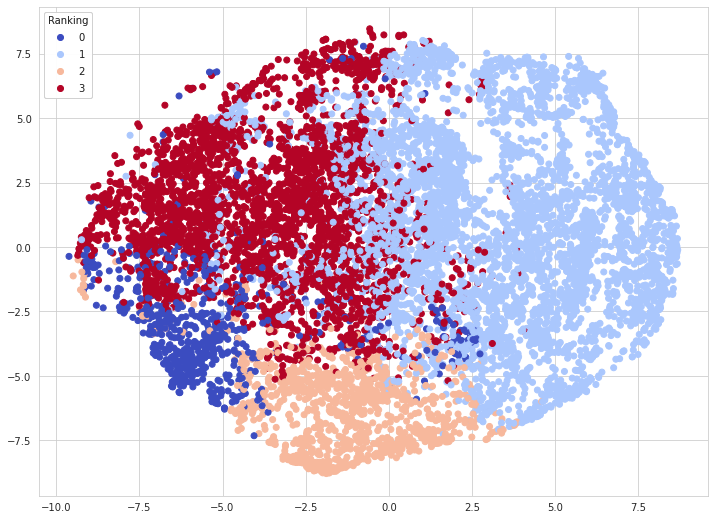

In [ ]:
fig = plt.figure(figsize=(12, 9))
ax = plt.axes()
x = tsne_result[:, 0]
y = tsne_result[:, 1]
#z = tsne_result[:, 2]
scatter = ax.scatter(x, y, c=res, cmap='coolwarm')
legend1 = ax.legend(*scatter.legend_elements(num=3),
                    loc="upper left", title="Ranking")
ax.add_artist(legend1)

### Интерпретация

In [ ]:
X = payments_groupped_vs.drop(
          [f'label_{i}' for i in range(0, num_classes)],
          #[f"('label', '', '')_{i}" for i in range(0, k)],
           axis=1
      )

In [ ]:
selected_features = []
selected_support = []
for num in range(0, num_classes):
  selector = SelectKBest(f_classif, k=3)
  selector.fit(
      X, payments_groupped_vs[f'label_{num}']
  )
  selected_features.append(selector.scores_)
  selected_support.append(selector.get_support())

In [ ]:
for num in range(0, num_classes):
  print(f'Label {num}')
  selector_mask = selected_support[num]
  column_names = payments_groupped_vs.columns[:-5]
  features = [column_names[i] for i, val in enumerate(selector_mask) if val]
  print(features)

Label 0
['Автоуслуги', 'Прочие розничные покупки', 'Топливо']
Label 1
['Красота', 'Одежда, Обувь', 'Прочие розничные покупки']
Label 2
['Cash', 'Дом, Ремонт', 'Супермаркеты']
Label 3
['Красота', 'Одежда, Обувь', 'Прочие розничные покупки']


In [ ]:
X['label'] = res

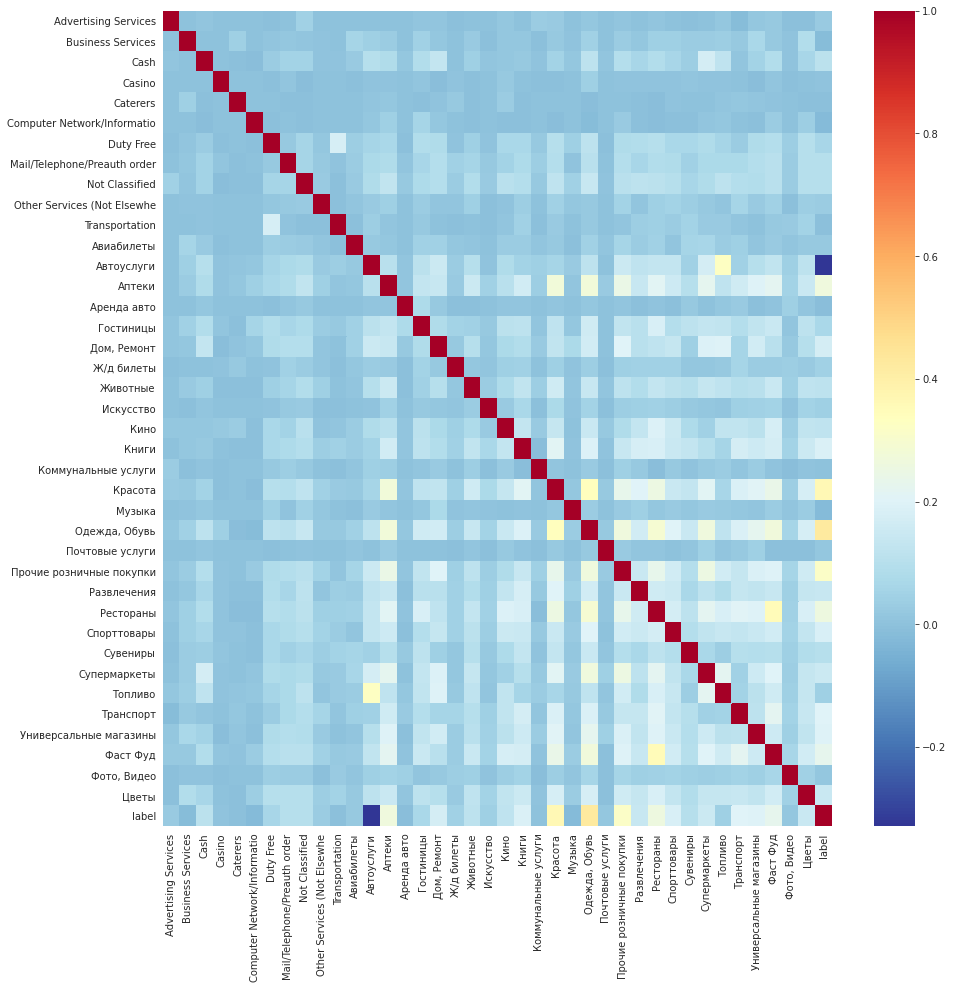

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(X.corr(), cmap="RdYlBu_r")

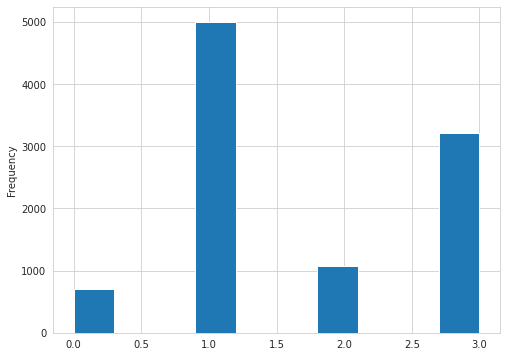

In [ ]:
X['label'].plot.hist()

Медианные суммы

*   Cash - более крупные снятия наличных у пользователей из класса 2, наименьшие - у класса 1
*   Advertising services - более крупные транзакции у класса 3
*   Casino - более крупные транзакции у классов 1, 3
*   Duty Free - более крупные транзакции у класса 3
*   Mail / Telephone - более крупные транзакции у класса 2
*   Автоуслуги - более крупные транзакции у класса 0, наименьшие у класса 3
*   Искусство - более крупные транзакции у класса 3
*   Красота - более крупные транзакции у класса 3, наименьшие - у класса 1
*   Одежда, обувь - более крупные транзакции у класса 3, наименьшие - у класса 1
*   Развлечения - более крупные транзакции у класса 3, наименьшие - у класса 1

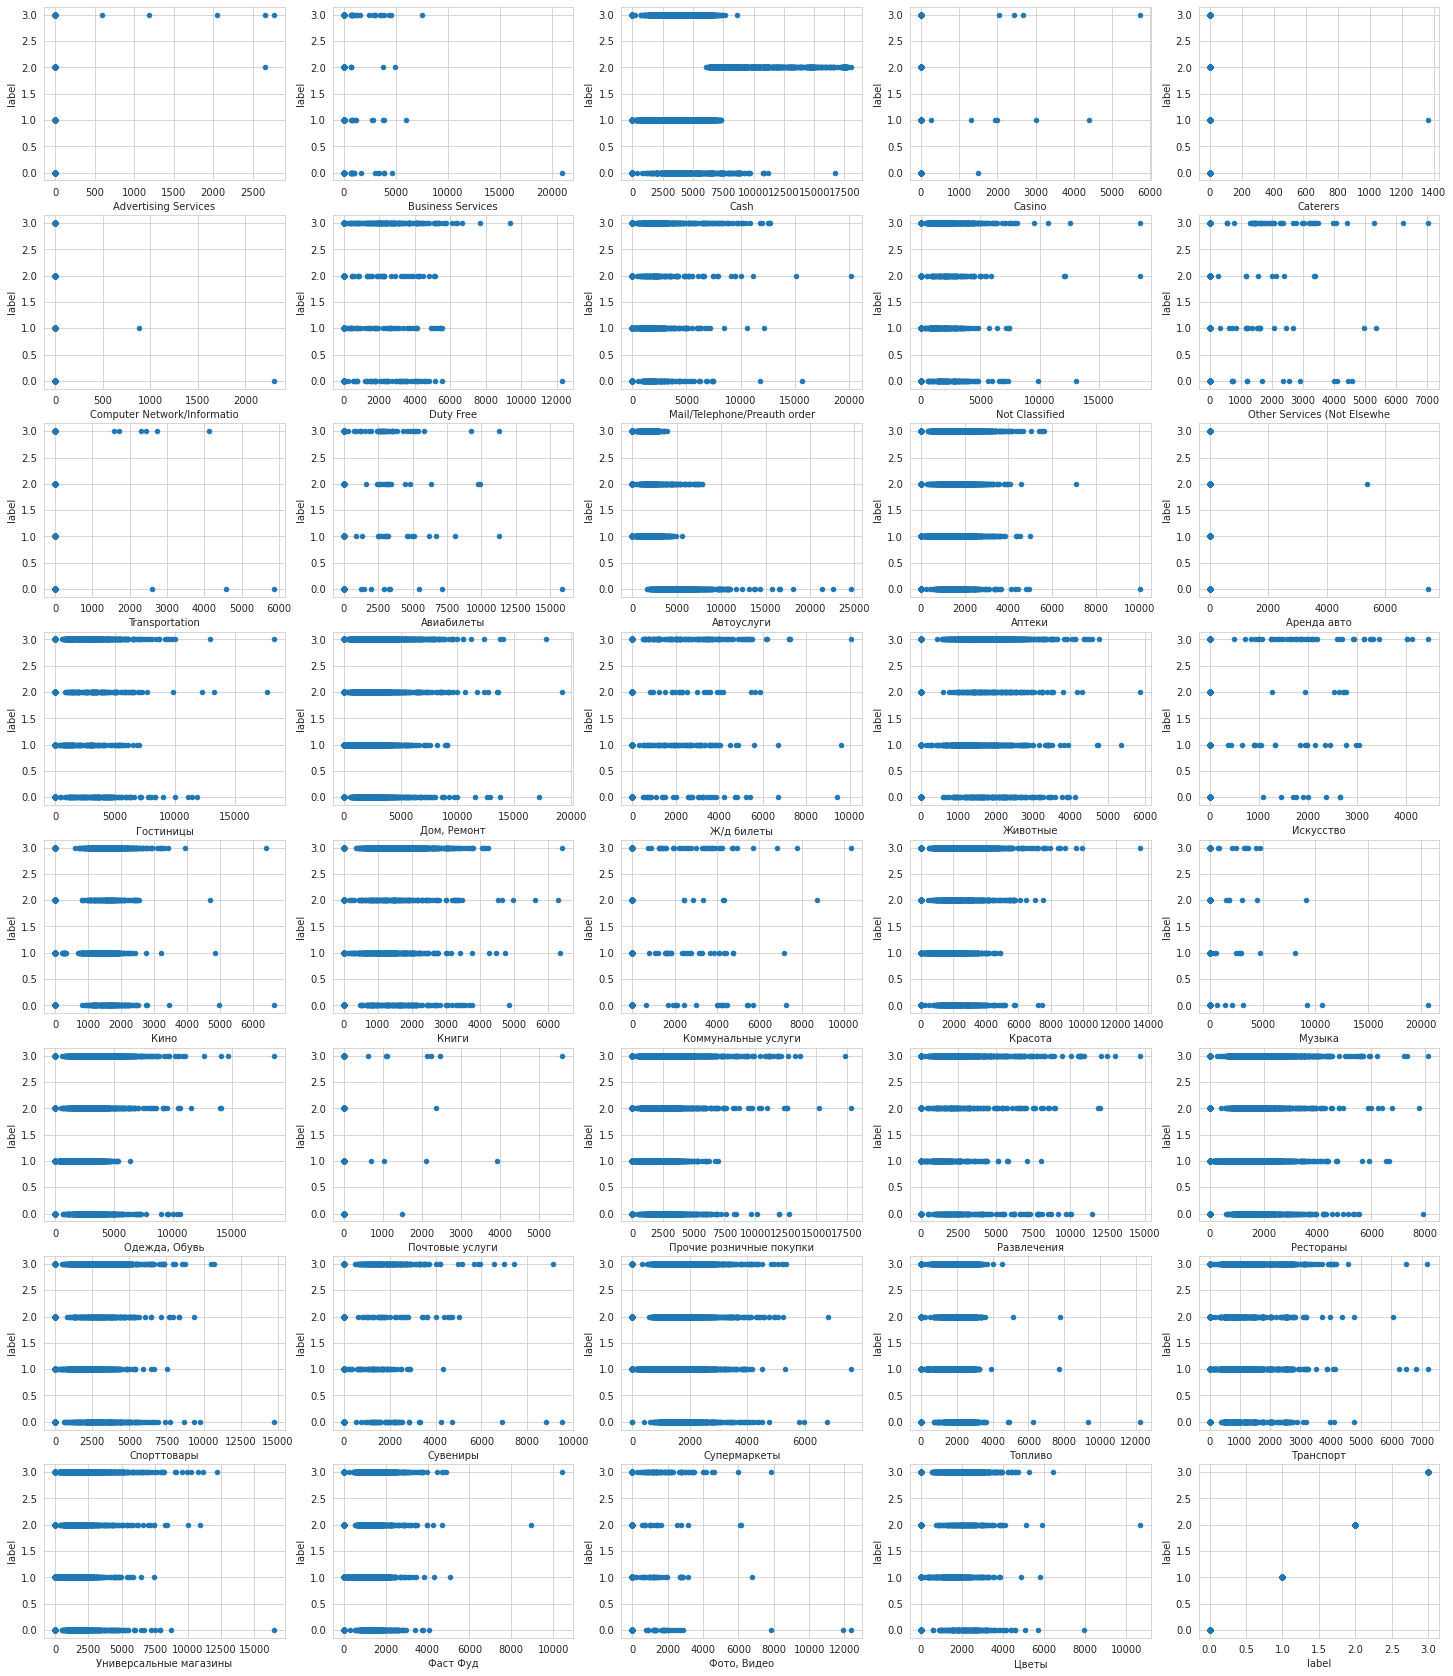

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(25, 30))
for idx, feature in enumerate(X.columns):
    X.plot(feature, "label", subplots=True, kind="scatter", ax=axes[idx // 5, idx % 5])

In [ ]:
X.index

Index(['0001f322716470bf9bfc1708f06f00fc', '0007297d86e14bd68bd87b1dbdefe302',
       '000b709c6c6fb1e8efcfd95e57c2a9de', '0027a7618d97cc9fbda55fac457eaeb7',
       '002b9f6e118c54f1292e03d1a04d516e', '0031915eb230f772681fb5dc5a8d1c31',
       '003360bff9882ca4a4f93394dd984822', '0037f3de3d890df1022cc760a1dfd9d6',
       '003fa58414cc55531fcc38423bea8f8e', '0046c2952fb808aa11f74abce5abe097',
       ...
       'ff70c3c5f2dca00f255705305d75111d', 'ff71bdbcba59047f1fad88dcb7052151',
       'ff7a887d347a8d598dc8e559d3aaec2f', 'ff7e1c6c07469b28a07847540385e767',
       'ff869ee855dc3f9b382c943eb43cc4ec', 'ff92d5420f5fb92a37e1280d1fc9e5f4',
       'ffaeae55d4dbf29058f04e7a6a764f02', 'ffc5289194413ec68c3f7adc8121d69b',
       'ffd097949a4a238296a7deadfb376cc0', 'ffdd5ec2a90e355cf40525eac1a6fd34'],
      dtype='object', name='customer_id', length=9985)

In [ ]:
data['label'] = data['customer_id'].apply(lambda x: X.at[x, 'label'])

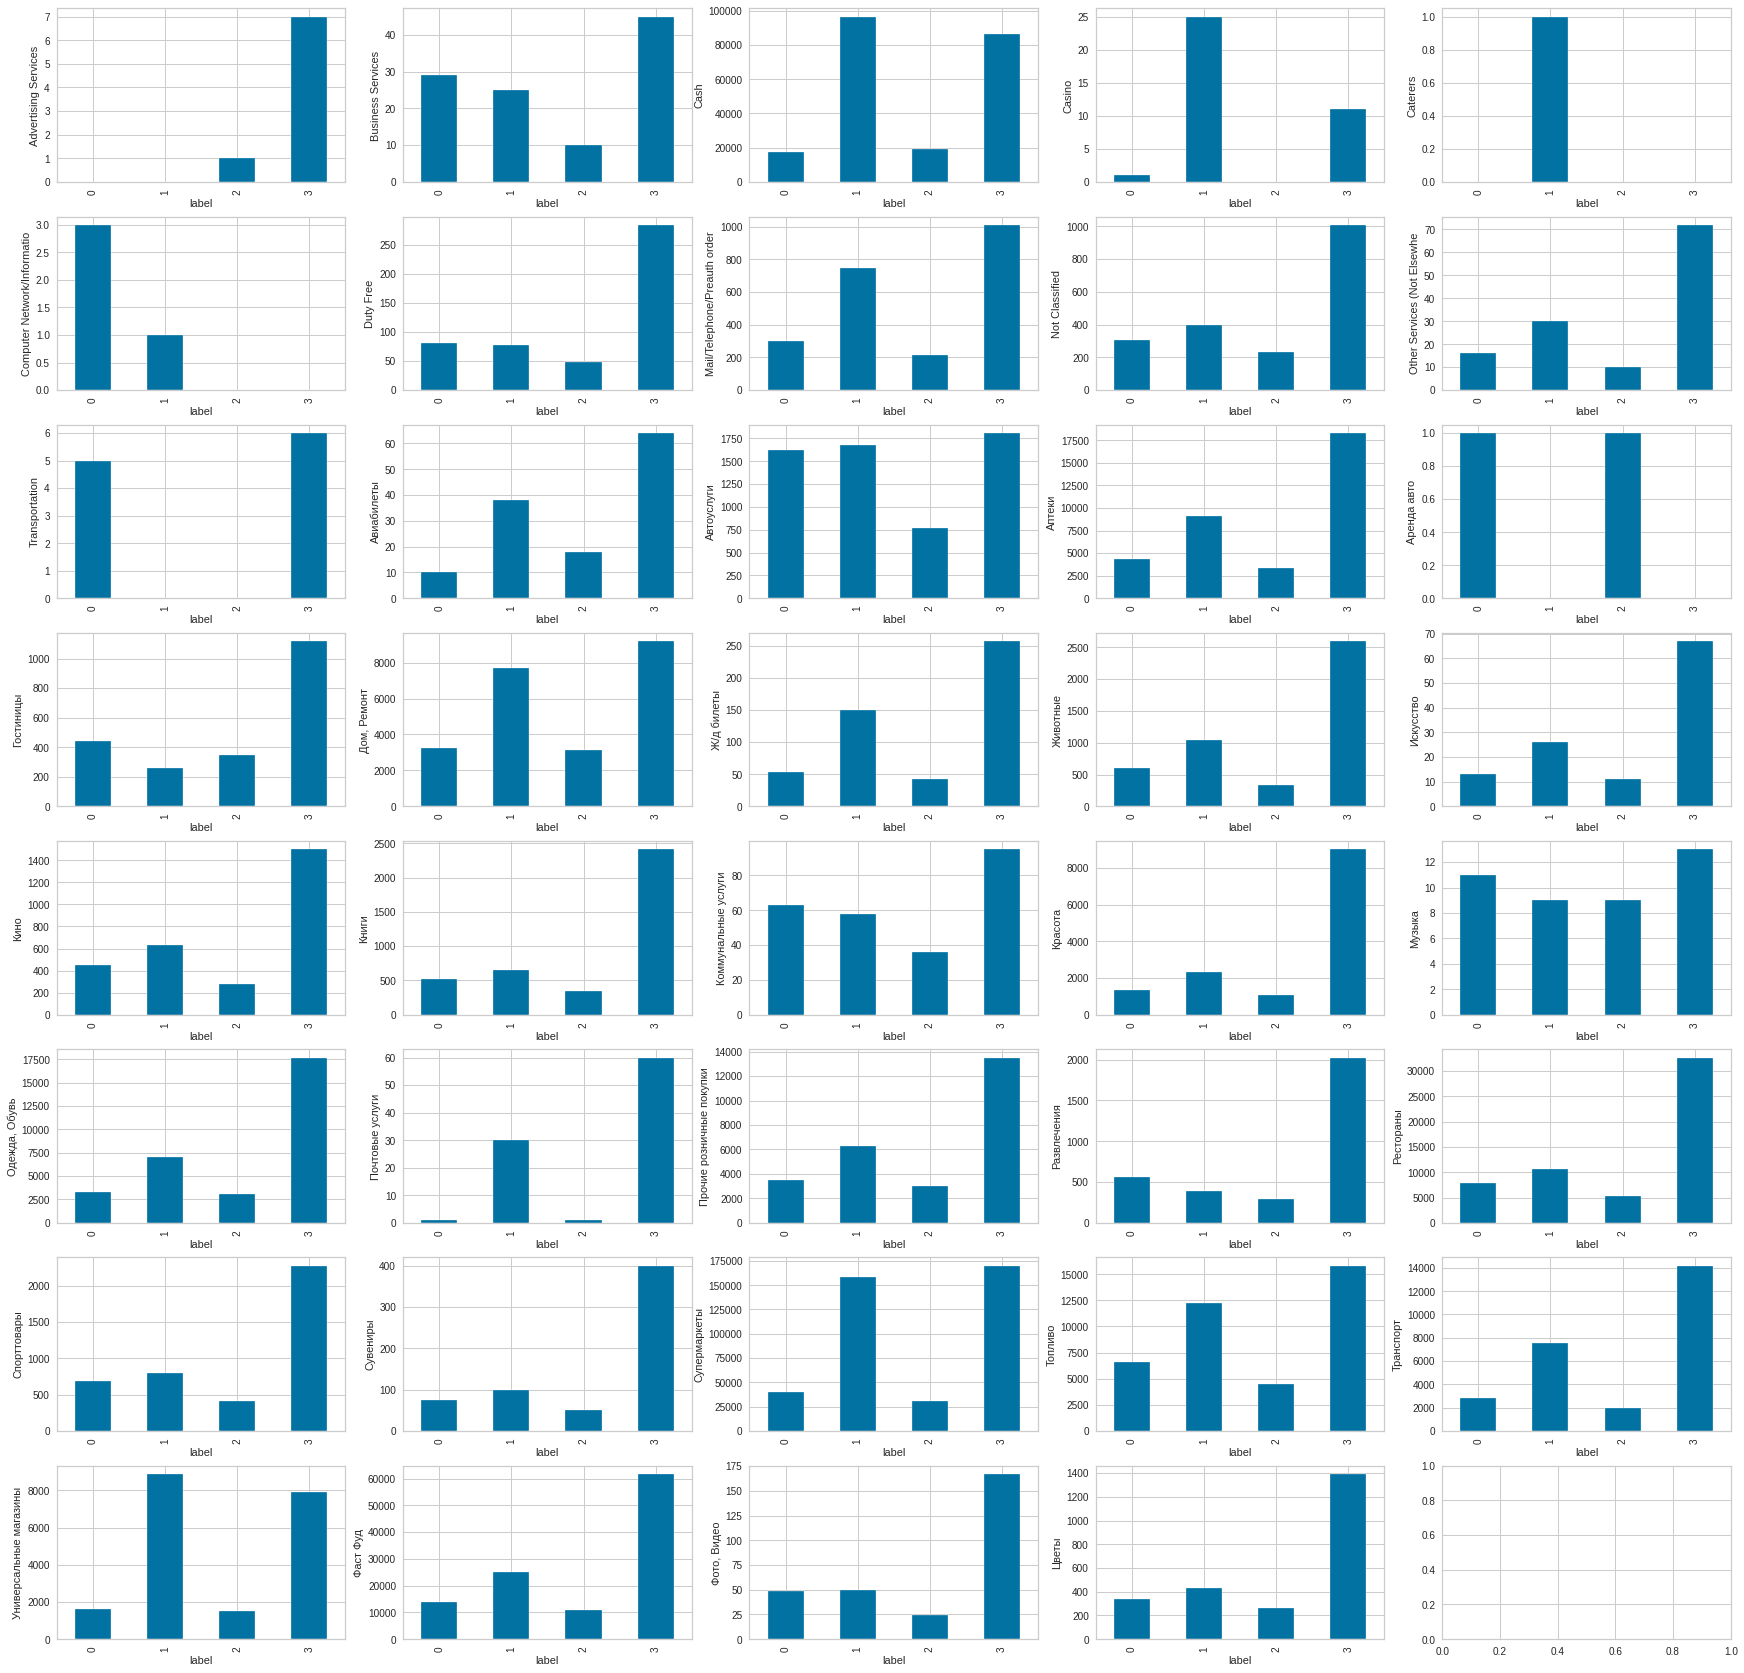

In [ ]:
agg_function = 'count'

if 1: 
  aggregated = data.groupby(['label', 'mcc_d1'])['amount'].aggregate(agg_function).unstack().fillna(0)
  fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(30, 30))
  for idx, feature in enumerate(aggregated.columns):
    axes[idx // 5, idx % 5].set_ylabel(feature)
    aggregated[feature].plot.bar(ax=axes[idx // 5, idx % 5])

In [ ]:
data['transaction_date'] = data['transaction_date'].apply(pd.to_datetime)
week_groupped = data[data['label'] == 3].groupby(['customer_id']).resample('W-Mon', on='transaction_date').sum()

In [ ]:
week_groupped.groupby(['customer_id']).mean().sort_values('amount', ascending=False)['amount'].head()

customer_id
3fd5bbeedcc183a5f2424f6a5fcb0669    80172.823704
5ac9db6c170b412c48870e3f9a60985a    63395.283335
82e5642fca5154c0eed76759d420440e    63282.725318
21e57f5cb268c388ed77b3c4ae85dbf0    60582.344799
9f63d1fd486f6c13f35d627f9eca3d1d    49620.307218
Name: amount, dtype: float64

## Классификация по полученным меткам

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.drop('label', axis=1), X['label'], test_size=0.2, random_state=SEED)

In [ ]:
X_test.head(1).values

array([[   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
        1913.8907598 ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        , 2523.40194225,    0.        ,    0.        ,
        1059.60820788, 1759.53816331,    0.        ,    0.        ,
           0.        ,    0.        , 1504.67464094]])

Распределение меток классов в тренировочном / тестовом наборах

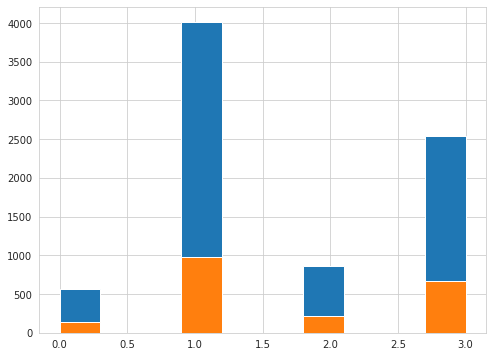

In [ ]:
y_train.hist()
y_test.hist()

In [ ]:
# TODO: crossvalidation

In [ ]:
%%time
clf = xgb.XGBClassifier(max_depth=5, objective='multi:softprob', n_estimators=100, num_classes=num_classes)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

CPU times: user 6.21 s, sys: 15.1 ms, total: 6.22 s
Wall time: 6.2 s


### Интерпретация 

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       135
           1       0.94      0.97      0.95       984
           2       0.96      0.98      0.97       214
           3       0.95      0.91      0.93       664

    accuracy                           0.94      1997
   macro avg       0.94      0.95      0.94      1997
weighted avg       0.95      0.94      0.94      1997



In [ ]:
X_rand = X_train.sample(1)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_rand)
shap.initjs()
for which_class in range(num_classes):
    display(shap.force_plot(explainer.expected_value[which_class], shap_values[which_class], X_rand))

rand_pred = clf.predict(X_rand)
rand_proba = clf.predict_proba(X_rand)

print(f'Predicted probability: {rand_proba[0]}')
print(f'Predicted label: {rand_pred[0]}','\n')

Predicted probability: [2.0744723e-04 5.4956795e-06 3.4265240e-06 9.9978369e-01]
Predicted label: 3 



In [ ]:
df1 = pd.DataFrame(data=shap_values[0], columns=X_train.columns, index=[0])
df2 = pd.DataFrame(data=shap_values[1], columns=X_train.columns, index=[1])
df3 = pd.DataFrame(data=shap_values[2], columns=X_train.columns, index=[2])
df3 = pd.DataFrame(data=shap_values[3], columns=X_train.columns, index=[3])
df = pd.concat([df1,df2,df3])
#display(df.transpose())

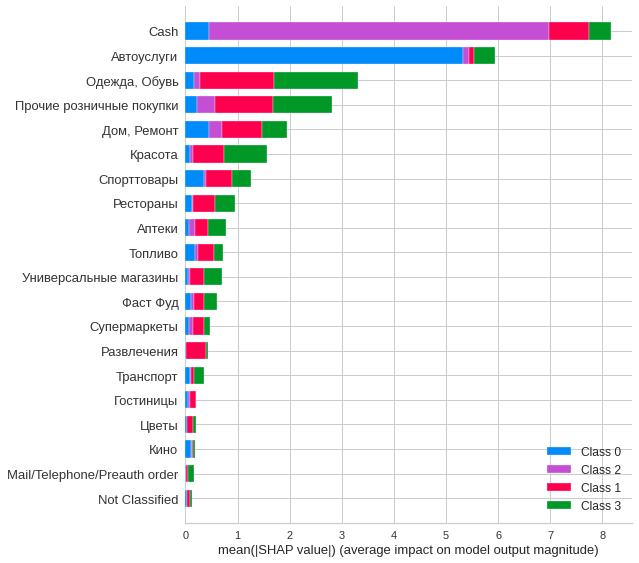

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test, approximate=True)
shap.summary_plot(shap_values, X_test, plot_type="bar")

### SHAP-значения для классов

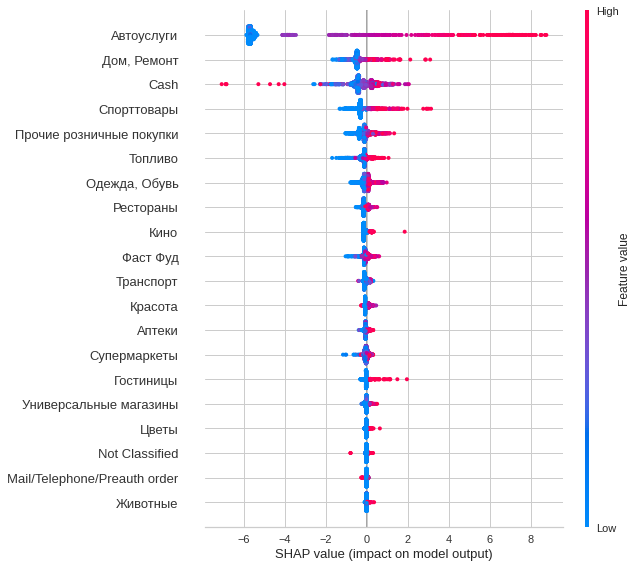

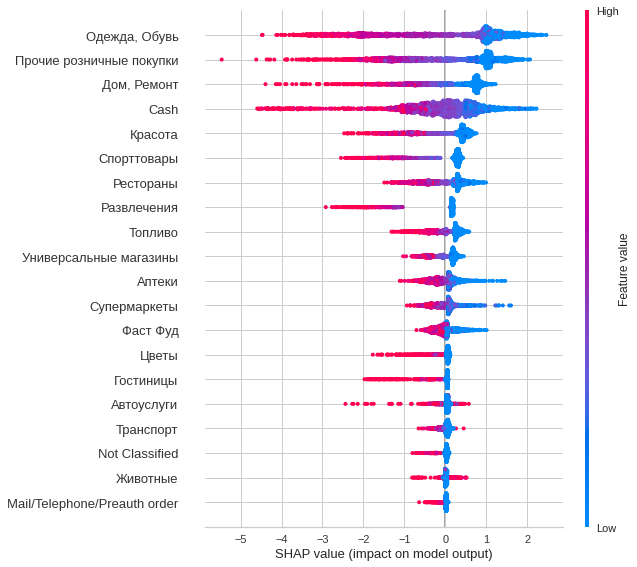

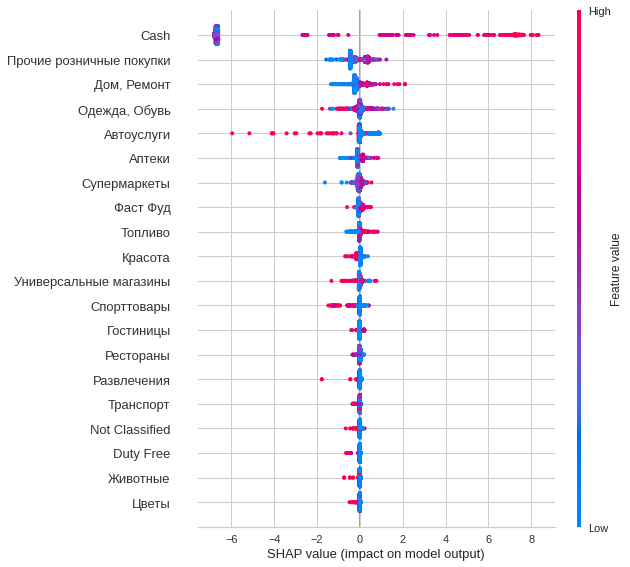

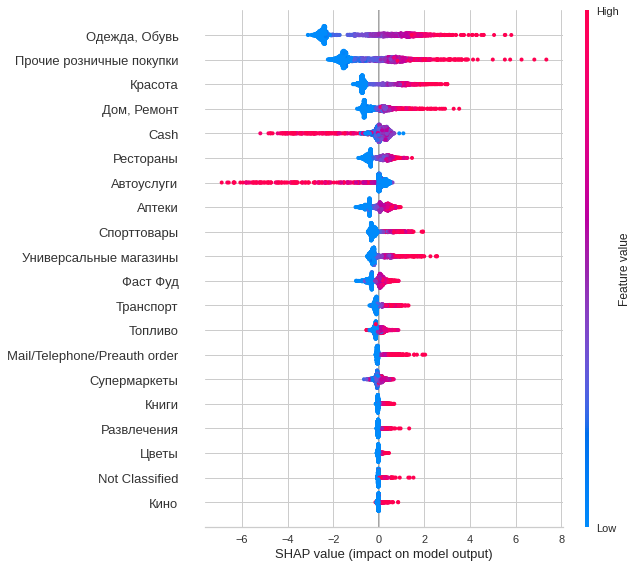

In [ ]:
for n_class in range(num_classes):
  shap.summary_plot(shap_values[n_class], X_test)

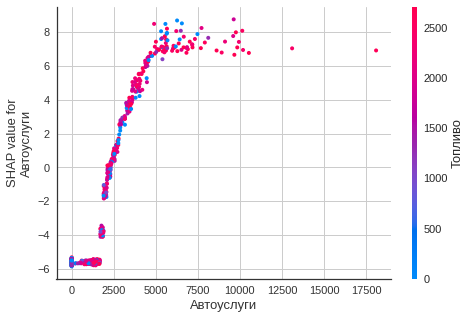

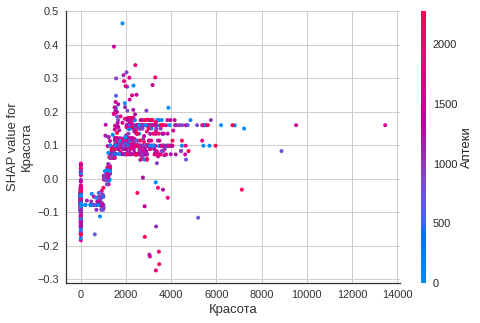

In [ ]:
pairs = [['Автоуслуги', 'Топливо'],
         ['Красота', 'Аптеки']]

for pair in pairs:
  shap.dependence_plot(pair[0], shap_values[0], X_test, interaction_index=pair[1])

## Геоданные


*   Определение геолокации
*   Операция за территорией РФ
*   Новая стабильная локация более 2-х месяцев




In [ ]:
def plot_geo_map(data_to_plot, lat_col, lon_col):
  plt.figure(1, figsize=(20,12))

  m1 = Basemap(projection='merc',
              llcrnrlat=-60,
              urcrnrlat=75,
              llcrnrlon=-180,
              urcrnrlon=180,
              lat_ts=0,
              resolution='c')

  m1.fillcontinents(color='#7892A4',lake_color='#000000') # dark grey land, black lakes
  m1.drawmapboundary(fill_color='#000000')                # black background
  m1.drawcountries(linewidth=0.2, color="#000000")        # thin white line for country borders

  # Plot the data
  home = m1(data_to_plot[lon_col].tolist(), data_to_plot[lat_col].tolist())
  m1.scatter(home[0], home[1], s=7, c="#E6171A", lw=0, alpha=1, zorder=5)

  plt.title("Geospatial data")
  plt.show()

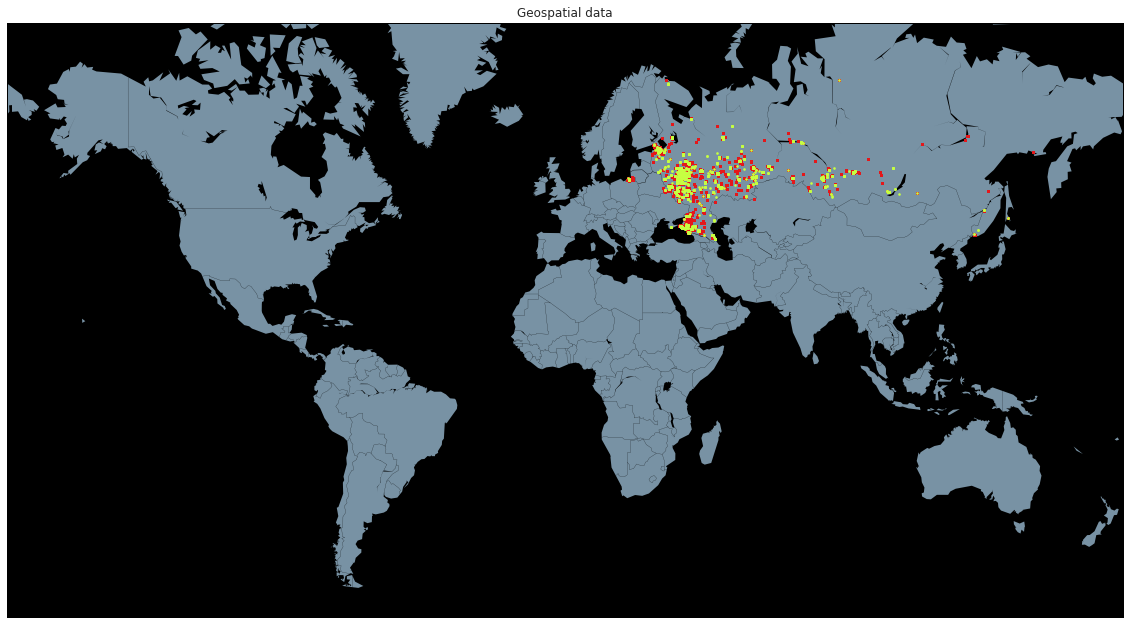

In [ ]:
plt.figure(1, figsize=(20,12))

m1 = Basemap(projection='merc',
             llcrnrlat=-60,
             urcrnrlat=75,
             llcrnrlon=-180,
             urcrnrlon=180,
             lat_ts=0,
             resolution='c')

m1.fillcontinents(color='#7892A4',lake_color='#000000') # dark grey land, black lakes
m1.drawmapboundary(fill_color='#000000')                # black background
m1.drawcountries(linewidth=0.2, color="#000000")        # thin white line for country borders

# Plot the data
home = m1(data["home_add_lon"].tolist(), data["home_add_lat"].tolist())
m1.scatter(home[0], home[1], s=7, c="#E6171A", lw=0, alpha=1, zorder=5)

work = m1(data["atm_address_lon"].tolist(), data["atm_address_lat"].tolist())
m1.scatter(work[0], work[1], s=7, c="#C6FF42", lw=0, alpha=1, zorder=5)

plt.title("Geospatial data")
plt.show()

Пользователи с максимальным количеством уникальных координат терминалов

In [ ]:
data.groupby('customer_id').nunique().sort_values('pos_adress_lat', ascending=False).head()

,amount,atm_address,atm_address_lat,atm_address_lon,city,country,currency,home_add_lat,home_add_lon,mcc,pos_address,pos_adress_lat,pos_adress_lon,terminal_id,transaction_date,work_add_lat,work_add_lon,mcc_d1,mcc_d2,label
customer_id,,,,,,,,,,,,,,,,,,,,
51598a20912cb082ff86ebe97c2e0798,887,48,23,21,77,1,1,1,1,44,272,238,238,428,209,0,0,26,33,1
626a2ee042e57904c098f4c904ef4694,475,24,26,26,52,1,2,1,1,41,206,188,188,285,167,1,1,22,27,1
20272f8f25487b762f2caa04b061fef8,564,21,33,33,47,1,1,1,1,28,173,162,162,278,169,0,0,16,18,1
5b128148da99be2999fded4b66b3e18c,535,29,21,19,33,1,1,1,1,38,176,145,145,301,171,1,1,22,25,1
d824da267b9458b23700ca2768759743,243,12,9,12,18,1,1,1,1,23,145,136,136,186,139,0,0,16,19,1


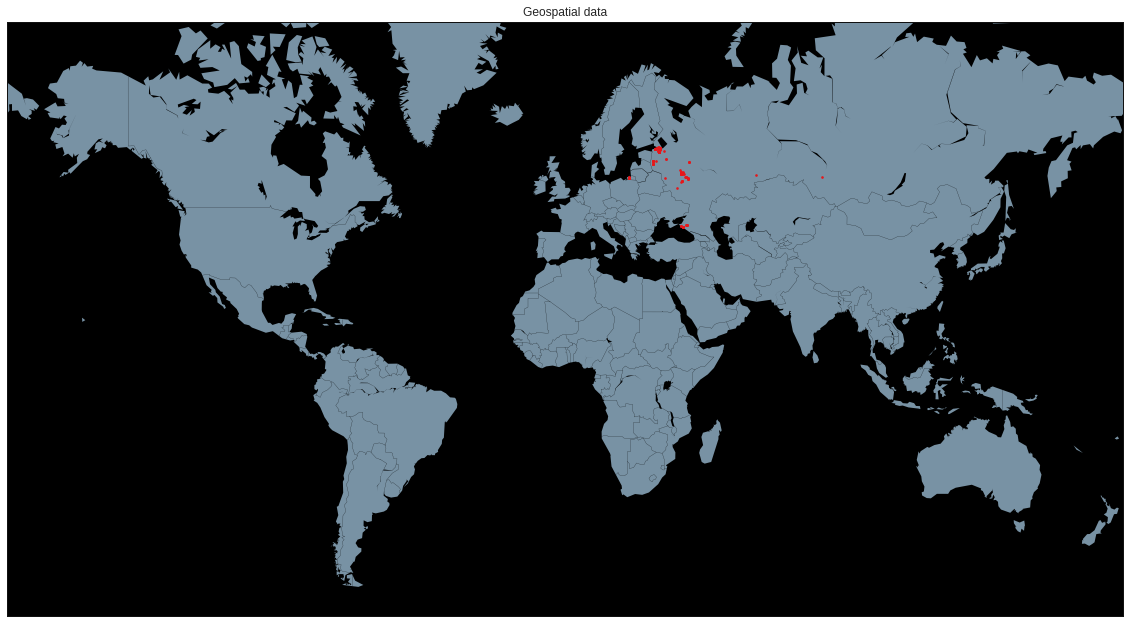

In [ ]:
plot_geo_map(data[data['customer_id'] == '51598a20912cb082ff86ebe97c2e0798'], 'pos_adress_lat', 'pos_adress_lon')

In [ ]:
from geopy.geocoders import Nominatim

In [ ]:
geolocator = Nominatim(user_agent="geoapiExercises")

In [ ]:
def get_location(latitude, longitude):
  loc_string = geolocator.reverse(f"{latitude},{longitude}")
  loc = loc_string.raw
  if 'address' not in loc:
    return loc_string
  if 'city' in loc['address']:
    return loc['address']['city']
  elif 'town' in loc['address']:
    return loc['address']['town']
  elif 'municipality' in loc['address']:
     return loc['address']['municipality']
  elif 'state' in loc['address']:
    return loc['address']['state']
  return loc_string

In [ ]:
def get_state(latitude, longitude):
  loc_string = geolocator.reverse(f"{latitude},{longitude}")
  loc = loc_string.raw
  if 'address' not in loc:
    return loc_string
  if 'state' in loc['address']:
    return loc['address']['state']
  return loc_string

In [ ]:
customer_pos_data = data[data['customer_id'] == '51598a20912cb082ff86ebe97c2e0798'].sort_values('transaction_date')[['transaction_date', 'atm_address_lat',	'atm_address_lon']].dropna()
customer_pos_data['location_name'] = customer_pos_data.apply(lambda x: get_location(x['atm_address_lat'], x['atm_address_lon']), axis=1)
customer_pos_data['state'] = customer_pos_data.apply(lambda x: get_state(x['atm_address_lat'], x['atm_address_lon']), axis=1)
customer_pos_data.head()

,transaction_date,atm_address_lat,atm_address_lon,location_name,state
1028058,2017-02-05,59.943,30.358,Санкт-Петербург,Санкт-Петербург
1028075,2017-02-06,59.948,30.360,Санкт-Петербург,Санкт-Петербург
1028065,2017-02-09,59.944,30.354,Санкт-Петербург,Санкт-Петербург
1019841,2017-02-10,55.748,37.536,Москва,Москва
1082018,2017-02-10,59.933,30.364,Санкт-Петербург,Санкт-Петербург


In [ ]:
customer_pos_data['state'].unique()

array(['Санкт-Петербург', 'Москва', 'Ленинградская область',
       'Краснодарский край'], dtype=object)

In [ ]:
previous_loc = customer_pos_data.iloc[0]['state']

for r, val in customer_pos_data.iterrows():
  if val['state'] != previous_loc:
    if (val['state'] == 'Санкт-Петербург' and previous_loc == 'Ленинградская область') or (val['state'] == 'Ленинградская область' and previous_loc == 'Санкт-Петербург'):
       continue
    print(f"{val['transaction_date']} {val['state']}")
  previous_loc = val['state']

2017-02-10 00:00:00 Москва
2017-02-10 00:00:00 Санкт-Петербург
2017-06-12 00:00:00 Краснодарский край
2017-06-15 00:00:00 Санкт-Петербург
2017-08-26 00:00:00 Москва
2017-08-27 00:00:00 Санкт-Петербург


## Мониторинг транзакций во времени



*   Оплачивают авиабилеты, гостиничные услуги
*   Оплачивают налоги
*   Снимают/ переводят деньги после зачислений



In [ ]:
data['transaction_date'] = data['transaction_date'].apply(pd.to_datetime)

In [ ]:
print(data['transaction_date'].min())
print(data['transaction_date'].max())

2017-01-27 00:00:00
2017-09-30 00:00:00


По дням и неделям

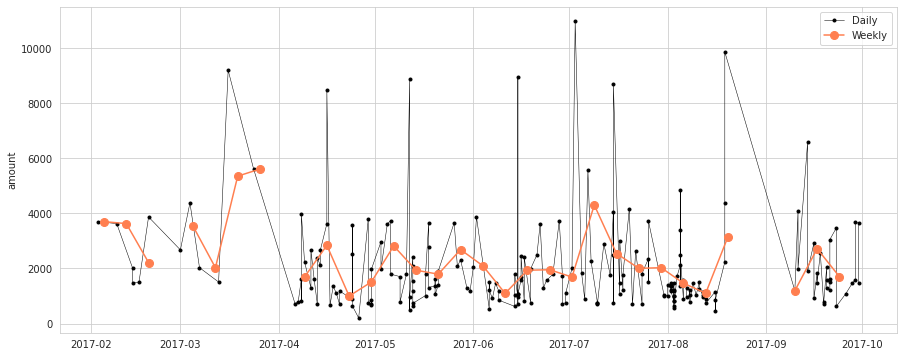

In [ ]:
userdata_week = userdata.resample("W").mean()

start, end = '2017-01-27', '2017-09-30'
fig, ax = plt.subplots()
ax.plot(userdata['amount'], marker='.', linestyle='-', linewidth = 0.5, label='Daily', color='black')
ax.plot(userdata_week.loc[start:end, 'amount'], marker='o', markersize=8, linestyle='-', label='Weekly', color='coral')
ax.set_ylabel("amount")
fig.set_size_inches(15, 6)
ax.legend()

Тепловая карта сумм транзакций по календарным дням для одного пользователя

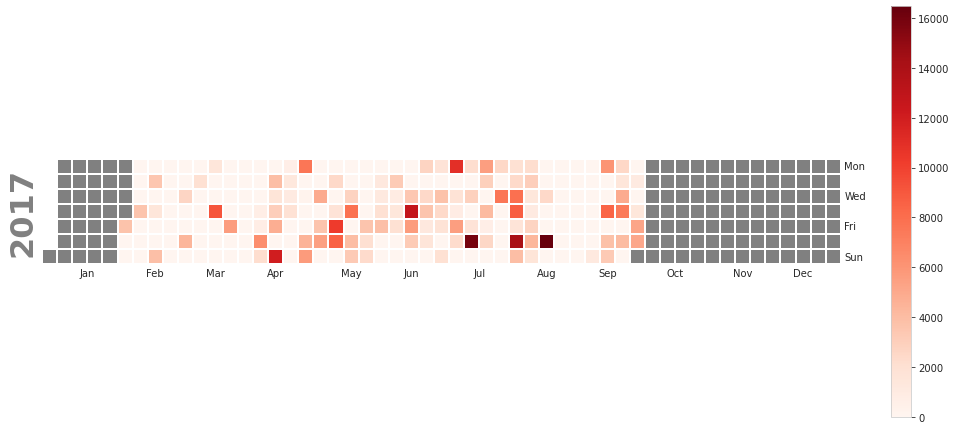

In [ ]:
fig, ax = calmap.calendarplot(userdata['amount'], monthticks=3, 
                    dayticks=[0, 2, 4, 6], fillcolor='grey', fig_kws=dict(figsize=(15, 6)))

fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist())

In [ ]:
userdata['mcc_d1'] = userdata['mcc'].apply(lambda x: mcc.loc[x]['Description_1'])

In [ ]:
userdata['mcc_d1'].unique()

array(['Cash', 'Супермаркеты', 'Цветы', 'Аптеки', 'Фаст Фуд', 'Рестораны',
       'Прочие розничные покупки', 'Книги', 'Красота', 'Сувениры',
       'Not Classified', 'Mail/Telephone/Preauth order', 'Транспорт',
       'Кино', 'Дом, Ремонт', 'Ж/д билеты', 'Одежда, Обувь', 'Топливо'],
      dtype=object)

Супермаркеты

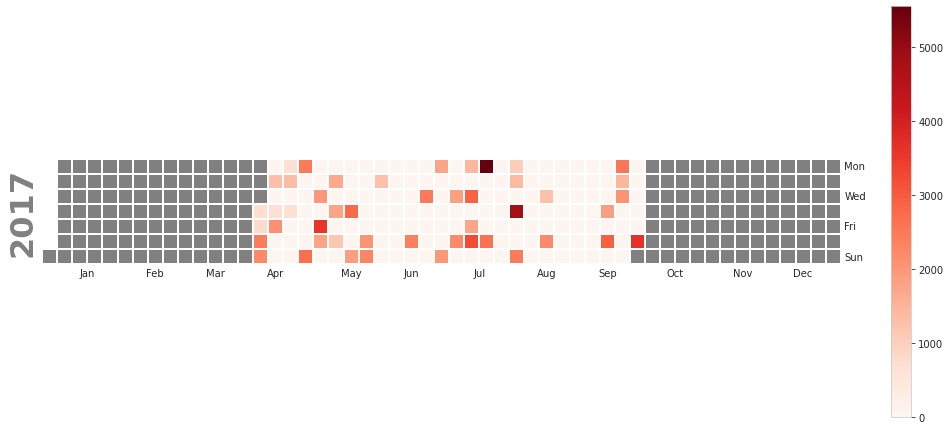

In [ ]:
fig, ax = calmap.calendarplot(userdata[userdata['mcc_d1'] == 'Супермаркеты']['amount'], monthticks=3, 
                    dayticks=[0, 2, 4, 6], fillcolor='grey', fig_kws=dict(figsize=(15, 6)))

fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist())

In [ ]:
userdata['transaction_date'] = userdata['transaction_date'].apply(pd.to_datetime)
userdata['week_day'] =  userdata['transaction_date'].dt.day_name()

In [ ]:
userdata.reset_index(drop=True).groupby(['mcc_d1', 'week_day']).agg({'amount': ['count', 'mean', 'sum']})

amount                           
                                        count         mean           sum
mcc_d1                       week_day                                   
Cash                         Friday         8  4582.721437  36661.771498
                             Monday         5  2434.583419  12172.917094
                             Saturday       9  4895.268227  44057.414046
                             Sunday         3  5320.256231  15960.768692
                             Thursday      15  3564.160068  53462.401021
                             Tuesday        4  2043.075198   8172.300790
                             Wednesday      7  2315.582094  16209.074657
Mail/Telephone/Preauth order Saturday       1  4387.181374   4387.181374
                             Thursday       1  1735.252820   1735.252820
Not Classified               Monday         1   753.532562    753.532562
                             Saturday       1   816.104523    816.104523
Аптеки                       Saturday       2  2188.526210   4377.052420
                             Sunday         1  1840.560917   1840.560917
                             Thursday       2  1205.279366   2410.558731
                             Tuesday        1   792.232199    792.232199
                             Wednesday      4  1040.660474   4162.641897
Дом, Ремонт                  Saturday       1  2107.296950   2107.296950
Ж/д билеты                   Saturday       1  3398.369095   3398.369095
Кино                         Tuesday        1  1025.908717   1025.908717
                             Wednesday      1  1189.218987   1189.218987
Книги                        Friday         1  1685.664850   1685.664850
                             Saturday       1  2096.882325   2096.882325
Красота                      Saturday       1  1460.046993   1460.046993
                             Sunday         1  1386.707108   1386.707108
Одежда, Обувь                Saturday       1  2501.774702   2501.774702
                             Thursday       1  1602.372522   1602.372522
Прочие розничные покупки     Friday         1   695.258725    695.258725
                             Monday         2  6388.586029  12777.172058
                             Saturday       1  2413.928905   2413.928905
                             Sunday         2  1497.134896   2994.269792
                             Thursday       1   883.379564    883.379564
                             Wednesday      2  1471.661522   2943.323044
Рестораны                    Friday         1  1181.026960   1181.026960
                             Monday         1   947.541762    947.541762
                             Saturday       2  1252.594602   2505.189204
                             Wednesday      5  1969.045627   9845.228136
Сувениры                     Friday         1  1581.647661   1581.647661
Супермаркеты                 Friday         4  2068.079677   8272.318707
                             Monday        10  1559.757402  15597.574024
                             Saturday      13  2062.084063  26807.092821
                             Sunday         8  1703.837350  13630.698799
                             Thursday      12  1122.425080  13469.100956
                             Tuesday        7  1217.318833   8521.231831
                             Wednesday      7  1794.290198  12560.031387
Топливо                      Friday         1  1507.113503   1507.113503
Транспорт                    Friday         1   762.851352    762.851352
                             Monday         1  1997.585291   1997.585291
Фаст Фуд                     Friday         6  1184.070082   7104.420490
                             Monday         5   860.424579   4302.122893
                             Saturday      11  1120.652632  12327.178950
                             Sunday         6   981.061812   5886.370873
                             Thursday       8  1008.518267   8068.146136
                        